In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import Simulator_Functions as SF
from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from log_progress import log_progress
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Default GPU Device: /device:GPU:0


Using TensorFlow backend.


In [2]:
## Network Model Parameters
Random_Seed = 42
model_name  = 'Single_Cross_Straight'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
program = 'DuelingDDQN' # DQN, DuelingDQN, DDQN, DuelingDDQN
reward_type = 'Queues'
state_type  = 'Queues'
PER_activated = True
## Use of additional files?
flag_read_additionally  = False
## Load trained model?
Demo_Mode = False
load_trained = False
Quickmode = True
SaveResultsAgent = True
# Random demand
Random_Demand = False

In [3]:
## Data handling flags
# Flag for restarting the COM Server
reset_flag = True
#cache_flag = False
# If a fresh start is needed, all previous results from simulations are deleted
Start_Fresh = True
# Debug action
debug_action = False

In [4]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 400
partial_save_at = 100
copy_weights_frequency = 5
reset_frequency = 100

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
simulation_length = 3600*1 + 1
memory_population_length = simulation_length*5

## State-Action Parameters
state_size = 4
action_size = 5

# Hyperparameters
batch_size = 64
memory_size = 1000
#alpha   = 0.0001
alpha   = 0.001

gamma   = 0.95

# Exploration Schedule
epsilon_start = 1
epsilon_end   = 0.001
epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
#epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes+1)) # Geometric decay

# Demand Schedule
demands = [100, 200, 400, 600, 800, 1000]
# Session ID
Session_ID = 'Episodes'+str(episodes)+'_Program'+program

In [5]:
if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    
    # If previous agents aren't to be loaded, proceed to memory population
    if not load_trained:
        # Initialize simulation
        if 'Vissim' not in globals() or Vissim == None:
            Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                        memory_population_length, Start_Fresh,\
                                                                        reset_flag = True, verbose = True)
        else:
            Vissim = com.Dispatch("Vissim.Vissim")
            Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                  memory_population_length, Start_Fresh, reset_flag = True)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))
    Vissim.Simulation.SetAttValue('SimRes', 1)


    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if program == "DQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = False,\
                           Dueling = False) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DuelingDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = False,\
                           Dueling = True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = True,\
                           Dueling = False) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif program == "DuelingDDQN":
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size, gamma, 0 if Demo_Mode else epsilon_start,\
                           epsilon_end, epsilon_decay, alpha, copy_weights_frequency, Vissim, PER_activated, DoubleDQN = True,\
                           Dueling = True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), program))
    
    if Demo_Mode:
        Agents = SF.load_agents(vissim_working_directory, model_name, Agents, Session_ID, best = True)
        SF.run_simulation_episode(Agents, Vissim, state_type, state_size, memory_population_length, Demo_Mode, PER_activated)
        Vissim = None
    # Load previous trained data
    elif load_trained:
        Agents = SF.load_agents(vissim_working_directory, model_name, Agents, Session_ID, best = False)
    # If previous data isn't to be loaded, have an initial longer random run to populate memory
    else:
        print('Pre-Populating memory with Random Actions....')
        SF.Set_Quickmode(Vissim)
        if PER_activated:
            memory = SF.PER_prepopulate_memory(Agents, Vissim, state_type, state_size, memory_size, vissim_working_directory, model_name)
        else:
            SF.run_simulation_episode(Agents, Vissim, state_type, state_size, memory_population_length, Demo_Mode, PER_activated)
        print('Memory pre-populated. Starting Training.\n')
    # Iterations of the simulation
    for episode in log_progress(range(episodes), every=1):
        # Completely re-dispatch server every N iterations for performance
        if episode % reset_frequency == 0 and episode !=0:
            Vissim = None
            Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                        simulation_length, Start_Fresh,\
                                                                        reset_flag = True, verbose = False)
            print("Redispatched")
        else:
            # If not the first episode, reset state at the start
            Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                simulation_length, Start_Fresh, reset_flag = True)
        npa = NetworkParser(Vissim) 
        for index, agent in enumerate(Agents):
            agent.update_IDS(npa.signal_controllers_ids[index], npa)
            agent.episode_reward = []
        
        # Change demand for every episode
        if Random_Demand:
            for vehicle_input in range(1,5):
                Vissim.Net.VehicleInputs.ItemByKey(vehicle_input).SetAttValue('Volume(1)', demands[np.random.randint(0,len(demands)-1)])    
        
        # Run Episode at maximum speed

        SF.Set_Quickmode(Vissim)
        SF.run_simulation_episode(Agents, Vissim, state_type, state_size, simulation_length, Demo_Mode, PER_activated)
        
        # Calculate episode average reward
        reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
        best_agent_weights = SF.best_agent(reward_storage, average_reward, best_agent_weights, vissim_working_directory, model_name, Agents, Session_ID)
        
        # Train agent with experience of episode (indicated batch size)
        for agent in Agents:
            agent.replay_batch(batch_size, episode)
            #break
        # Security save for long trainings
        if SaveResultsAgent:
            if (episode+1)%partial_save_at == 0:
                SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                print('Saved Partial results at the end of episode {}.'.format(episode+1))

    #Saving agents memory, weights and optimizer
    if SaveResultsAgent:
        SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
        print("Model, architecture, weights, optimizer, memory and training results succesfully saved. Succesfully Terminated.")
    
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Loading Model File: Single_Cross_Straight.inpx ...
Load process successful
Simulation length set to 1800.5 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Instructions for updating:
Colocations handled automatically by placer.
Deploying ins

Episode: 1/400, Epsilon:1, Average reward: -225.58
Prediction for [500,0,500,0] is: [[ 297.04907   -195.93985    -38.784054  -191.87808      1.2576103]]
New best agent found. Saved in C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Single_Cross_Straight\Single_Cross_Straight_Episodes400_ProgramDuelingDDQN_BestAgent0_Memory.p
Instructions for updating:
Use tf.cast instead.
Episode: 2/400, Epsilon:1.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ 264.38873 -216.46681 -108.30971 -219.2912   -68.62274]]
New best agent found. Saved in C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Single_Cross_Straight\Single_Cross_Straight_Episodes400_ProgramDuelingDDQN_BestAgent0_Memory.p
Episode: 3/400, Epsilon:0.99, Average reward: -84.97
Prediction for [500,0,500,0] is: [[ 217.47342 -249.41751 -162.04343 -239.66422 -134.51259]]
Episode: 4/400, Epsilon:0.99, Average reward

Prediction for [500,0,500,0] is: [[-0.56988454 -0.5194695  -0.815886   -1.0345848  -1.0622852 ]]
Episode: 43/400, Epsilon:0.87, Average reward: -67.5
Prediction for [500,0,500,0] is: [[-0.5829879 -0.5339271 -0.8335791 -1.0621606 -1.0863833]]
New best agent found. Saved in C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Vissim\Single_Cross_Straight\Single_Cross_Straight_Episodes400_ProgramDuelingDDQN_BestAgent0_Memory.p
Episode: 44/400, Epsilon:0.87, Average reward: -228.85
Prediction for [500,0,500,0] is: [[-0.5961172  -0.54788387 -0.85116404 -1.089905   -1.1086133 ]]
Episode: 45/400, Epsilon:0.87, Average reward: -375.38
Prediction for [500,0,500,0] is: [[-0.6091546  -0.56172866 -0.8683979  -1.1158863  -1.1340188 ]]
Weights succesfully copied to Target model.
Episode: 46/400, Epsilon:0.86, Average reward: -83.51
Prediction for [500,0,500,0] is: [[-0.6217737  -0.5762103  -0.88556194 -1.1414678  -1.158743  ]]
Episode: 47/400, Epsilon:0

Episode: 90/400, Epsilon:0.73, Average reward: -70.77
Prediction for [500,0,500,0] is: [[-1.1067271 -1.1486137 -1.7664896 -2.282222  -2.160071 ]]
Weights succesfully copied to Target model.
Episode: 91/400, Epsilon:0.73, Average reward: -68.95
Prediction for [500,0,500,0] is: [[-1.1184905 -1.1635574 -1.7836001 -2.309311  -2.1832817]]
Episode: 92/400, Epsilon:0.73, Average reward: -341.46
Prediction for [500,0,500,0] is: [[-1.1294119 -1.1790354 -1.8010937 -2.3339126 -2.2070894]]
Episode: 93/400, Epsilon:0.72, Average reward: -281.16
Prediction for [500,0,500,0] is: [[-1.1402872 -1.1944773 -1.817835  -2.3573747 -2.231186 ]]
Episode: 94/400, Epsilon:0.72, Average reward: -225.58
Prediction for [500,0,500,0] is: [[-1.1521039 -1.2095714 -1.8335781 -2.3824577 -2.254877 ]]
Episode: 95/400, Epsilon:0.72, Average reward: -83.51
Prediction for [500,0,500,0] is: [[-1.1638818 -1.222916  -1.8518268 -2.4068413 -2.2782824]]
Weights succesfully copied to Target model.
Episode: 96/400, Epsilon:0.71, Av

Episode: 131/400, Epsilon:0.61, Average reward: -228.85
Prediction for [500,0,500,0] is: [[-1.6152091 -1.6863027 -2.4967744 -3.374705  -3.1544375]]
Episode: 132/400, Epsilon:0.61, Average reward: -102.61
Prediction for [500,0,500,0] is: [[-1.6296513 -1.7003899 -2.5187728 -3.3990781 -3.1781147]]
Episode: 133/400, Epsilon:0.6, Average reward: -217.89
Prediction for [500,0,500,0] is: [[-1.6434591 -1.7149596 -2.5411878 -3.4236236 -3.2013817]]
Episode: 134/400, Epsilon:0.6, Average reward: -68.95
Prediction for [500,0,500,0] is: [[-1.656596  -1.7287793 -2.5651686 -3.450439  -3.2234738]]
Episode: 135/400, Epsilon:0.6, Average reward: -242.96
Prediction for [500,0,500,0] is: [[-1.6698844 -1.7416031 -2.587871  -3.4792032 -3.247181 ]]
Weights succesfully copied to Target model.
Episode: 136/400, Epsilon:0.59, Average reward: -375.38
Prediction for [500,0,500,0] is: [[-1.6841719 -1.7539837 -2.6096663 -3.508621  -3.2704551]]
Episode: 137/400, Epsilon:0.59, Average reward: -70.77
Prediction for [5

Episode: 183/400, Epsilon:0.45, Average reward: -84.97
Prediction for [500,0,500,0] is: [[-2.3807626 -2.4061754 -3.5825858 -4.8268147 -4.5149646]]
Episode: 184/400, Epsilon:0.45, Average reward: -281.16
Prediction for [500,0,500,0] is: [[-2.3967457 -2.4203289 -3.6052637 -4.8566437 -4.5462403]]
Episode: 185/400, Epsilon:0.45, Average reward: -68.95
Prediction for [500,0,500,0] is: [[-2.4132814 -2.4343903 -3.628313  -4.888326  -4.578239 ]]
Weights succesfully copied to Target model.
Episode: 186/400, Epsilon:0.44, Average reward: -68.95
Prediction for [500,0,500,0] is: [[-2.4317427 -2.4481392 -3.6515062 -4.920046  -4.609375 ]]
Episode: 187/400, Epsilon:0.44, Average reward: -217.89
Prediction for [500,0,500,0] is: [[-2.4497108 -2.462885  -3.674968  -4.951398  -4.6400785]]
Episode: 188/400, Epsilon:0.44, Average reward: -68.95
Prediction for [500,0,500,0] is: [[-2.467303  -2.4788923 -3.6978664 -4.9838243 -4.672372 ]]
Episode: 189/400, Epsilon:0.44, Average reward: -68.95
Prediction for [5

Episode: 230/400, Epsilon:0.31, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-3.3386073 -3.241648  -4.671995  -6.308641  -6.0975704]]
Weights succesfully copied to Target model.
Episode: 231/400, Epsilon:0.31, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-3.3612633 -3.2625387 -4.6976104 -6.3456535 -6.1321034]]
Episode: 232/400, Epsilon:0.31, Average reward: -83.51
Prediction for [500,0,500,0] is: [[-3.3835511 -3.283235  -4.7243705 -6.383334  -6.1670833]]
Episode: 233/400, Epsilon:0.3, Average reward: -215.76
Prediction for [500,0,500,0] is: [[-3.40688   -3.3050737 -4.7489476 -6.421255  -6.20538  ]]
Episode: 234/400, Epsilon:0.3, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-3.4315813 -3.327188  -4.7725005 -6.4596233 -6.245004 ]]
Episode: 235/400, Epsilon:0.3, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-3.4565942 -3.3492248 -4.7961626 -6.497142  -6.2829814]]
Weights succesfully copied to Target model.
Episode: 236/400, Epsilon:0.29, 

Episode: 280/400, Epsilon:0.16, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-4.611483 -4.520187 -5.92421  -8.288145 -8.014   ]]
Weights succesfully copied to Target model.
Episode: 281/400, Epsilon:0.16, Average reward: -70.77
Prediction for [500,0,500,0] is: [[-4.6428022 -4.5509987 -5.950483  -8.330469  -8.058073 ]]
Episode: 282/400, Epsilon:0.16, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-4.673191  -4.5813446 -5.9774003 -8.3750305 -8.102375 ]]
Episode: 283/400, Epsilon:0.15, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-4.703266  -4.6121907 -6.0050416 -8.4193535 -8.146255 ]]
Episode: 284/400, Epsilon:0.15, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-4.733342  -4.64425   -6.0317903 -8.462749  -8.186456 ]]
Episode: 285/400, Epsilon:0.15, Average reward: -69.31
Prediction for [500,0,500,0] is: [[-4.761737  -4.6750484 -6.0605226 -8.508108  -8.226862 ]]
Weights succesfully copied to Target model.
Episode: 286/400, Epsilon:0.14, Ave

Episode: 328/400, Epsilon:0.02, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.1501503  -6.302632   -7.295701  -10.273225  -10.122703 ]]
Episode: 329/400, Epsilon:0.01, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.1874113  -6.340662   -7.3252897 -10.318562  -10.170244 ]]
Episode: 330/400, Epsilon:0.01, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.2236     -6.379027   -7.3553104 -10.363367  -10.2142315]]
Weights succesfully copied to Target model.
Episode: 331/400, Epsilon:0.01, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.259718   -6.4173813  -7.387257  -10.408665  -10.257368 ]]
Episode: 332/400, Epsilon:0.01, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.2949963  -6.454743   -7.418244  -10.452078  -10.302732 ]]
Episode: 333/400, Epsilon:0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -6.330834   -6.4915724  -7.4479856 -10.496     -10.348286 ]]
Episode: 334/400, Epsilon:-0.0, Average rewar

Episode: 380/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.250038   -8.355526   -8.823478  -12.5220995 -12.598385 ]]
Weights succesfully copied to Target model.
Episode: 381/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.300169  -8.400641  -8.851257 -12.563461 -12.64567 ]]
Episode: 382/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.350058  -8.445636  -8.879262 -12.605606 -12.691509]]
Episode: 383/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.399757  -8.489639  -8.906754 -12.645336 -12.735038]]
Episode: 384/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.450327   -8.5348015  -8.935473  -12.687384  -12.778341 ]]
Episode: 385/400, Epsilon:-0.0, Average reward: -68.95
Prediction for [500,0,500,0] is: [[ -8.5010395  -8.578939   -8.96453   -12.727119  -12.822042 ]]
Weights succesfully copied to Target model.
Episode: 386/40

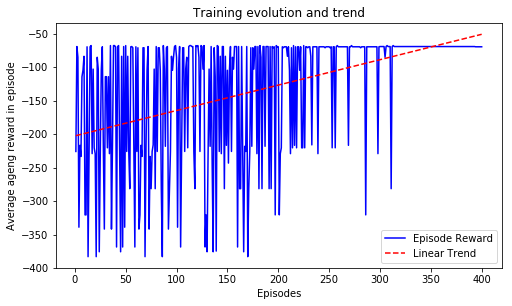

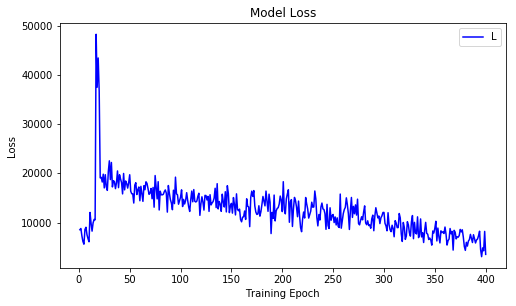

In [7]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average ageng reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()